## Load Data

**Mount Drive**

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Import Data**

In [76]:
import pandas as pd

# import data 
df_true = pd.read_csv('/content/drive/MyDrive/Deep learning/Final Project/Data/True.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/Deep learning/Final Project/Data/Fake.csv')

In [217]:
df_true.title[0]

'As U.S. budget fight looms, Republicans flip their fiscal script'

In [44]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [77]:
# add labels
# 1 indicates true, 0 indicates fake
df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake])

# shuffle dataframe and reset the index
df = df.sample(frac=1).reset_index(drop=True)

In [78]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [79]:
# select politics news
df = df.query('subject=="politicsNews" | subject=="politics"').reset_index(drop=True)
len(df)

18113

**Split Dataset**

In [80]:
from sklearn.model_selection import train_test_split

text = df['title']
label = df['label']
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.3, random_state=0, stratify=label)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

print('Training length:', len(x_train))
print('Validation length:', len(x_validation))
print('Test length:', len(x_test))

Training length: 8875
Validation length: 3804
Test length: 5434


## Preprocess Data

In [170]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 15000

max_len = 100
batch_size = 128

# Tokenize (Vectorize a text corpus)
token = Tokenizer(num_words=max_features,     # The maximum number of words to keep
                  lower=True)                 # Convert texts to lowercase
token.fit_on_texts(x_train)
X_train = token.texts_to_sequences(x_train)
X_validation = token.texts_to_sequences(x_validation)
X_test = token.texts_to_sequences(x_test)

print('%s unique tokens' %len(token.word_index))

X_train = pad_sequences(X_train, maxlen=max_len)
X_validation = pad_sequences(X_validation, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('Training shape:', X_train.shape)
print('Validation shape:', X_validation.shape)
print('Test shape:', X_test.shape)

14446 unique tokens
Training shape: (8875, 100)
Validation shape: (3804, 100)
Test shape: (5434, 100)


In [82]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from keras import layers
from keras.optimizers import RMSprop
import keras
import matplotlib.pyplot as plt

## Simple RNN
### batch size=128 - overfitting problem

In [134]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs

model.add(Embedding(max_features, 64, input_length=max_len))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 64)`.

model.add(SimpleRNN(16, return_sequences=True))
model.add(SimpleRNN(8, return_sequences=True))
model.add(SimpleRNN(8)) # default activation is "tanh"
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           960000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 16)           1296      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 8)            200       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 961,641
Trainable params: 961,641
Non-trainable params: 0
_________________________________________________________________


In [135]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/20
70/70 [==============================] - 8s 83ms/step - loss: 0.4295 - accuracy: 0.7386 - val_loss: 0.2130 - val_accuracy: 0.8585
Epoch 2/20
70/70 [==============================] - 6s 79ms/step - loss: 0.1522 - accuracy: 0.9357 - val_loss: 0.1569 - val_accuracy: 0.9085
Epoch 3/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0789 - accuracy: 0.9750 - val_loss: 0.1270 - val_accuracy: 0.9179
Epoch 4/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0385 - accuracy: 0.9913 - val_loss: 0.1102 - val_accuracy: 0.9286
Epoch 5/20
70/70 [==============================] - 6s 79ms/step - loss: 0.0245 - accuracy: 0.9948 - val_loss: 0.1036 - val_accuracy: 0.9326
Epoch 6/20
70/70 [==============================] - 6s 81ms/step - loss: 0.0166 - accuracy: 0.9970 - val_loss: 0.0963 - val_accuracy: 0.9385
Epoch 7/20
70/70 [==============================] - 6s 80ms/step - loss: 0.0124 - accuracy: 0.9980 - val_loss: 0.0942 - val_accuracy: 0.9334
Epoch 8/20
70

### add l2 regularizer
### add early stopping
### delete one layer

In [139]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs

model.add(Embedding(max_features, 64, input_length=max_len))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 64)`.

model.add(SimpleRNN(16, return_sequences=True,kernel_regularizer='l2'))
#model.add(SimpleRNN(8, return_sequences=True))
model.add(SimpleRNN(8)) # default activation is "tanh"
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           960000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 16)           1296      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 961,505
Trainable params: 961,505
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test),callbacks = Es)

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 6s 69ms/step - loss: 0.7252 - accuracy: 0.5959 - val_loss: 0.4437 - val_accuracy: 0.8184
Epoch 2/50
70/70 [==============================] - 4s 63ms/step - loss: 0.3633 - accuracy: 0.9052 - val_loss: 0.3329 - val_accuracy: 0.8798
Epoch 3/50
70/70 [==============================] - 4s 63ms/step - loss: 0.2301 - accuracy: 0.9584 - val_loss: 0.2669 - val_accuracy: 0.8995
Epoch 4/50
70/70 [==============================] - 4s 62ms/step - loss: 0.1525 - accuracy: 0.9791 - val_loss: 0.2131 - val_accuracy: 0.9201
Epoch 5/50
70/70 [==============================] - 4s 62ms/step - loss: 0.1031 - accuracy: 0.9913 - val_loss: 0.1704 - val_accuracy: 0.9304
Epoch 6/50
70/70 [==============================] - 4s 61ms/step - loss: 0.0731 - accuracy: 0.9942 - val_loss: 0.1581 - val_accuracy: 0.9249
Epoch 7/50
70/70 [==============================] - 4s 61ms/step - loss: 0.0544 - accuracy: 0.9967 - val_loss: 0.1359 - val_accuracy: 0.9398
Epoch 8/50
70

### change the batch size to 8; others remain the same - improve the overfitting problem, but time consuming

In [142]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs

model.add(Embedding(max_features, 64, input_length=max_len))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 64)`.

model.add(SimpleRNN(16, return_sequences=True,kernel_regularizer='l2'))
#model.add(SimpleRNN(8, return_sequences=True))
model.add(SimpleRNN(8)) # default activation is "tanh"
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           960000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 16)           1296      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 961,505
Trainable params: 961,505
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test),callbacks = Es)

keras.backend.clear_session()
del model

Epoch 1/50
1110/1110 [==============================] - 47s 41ms/step - loss: 0.4364 - accuracy: 0.7664 - val_loss: 0.2143 - val_accuracy: 0.8484
Epoch 2/50
1110/1110 [==============================] - 46s 41ms/step - loss: 0.1421 - accuracy: 0.9082 - val_loss: 0.1545 - val_accuracy: 0.8866
Epoch 3/50
1110/1110 [==============================] - 46s 41ms/step - loss: 0.1039 - accuracy: 0.9325 - val_loss: 0.2414 - val_accuracy: 0.7854
Epoch 4/50
1110/1110 [==============================] - 45s 41ms/step - loss: 0.2155 - accuracy: 0.8011 - val_loss: 0.1165 - val_accuracy: 0.9336
Epoch 5/50
1110/1110 [==============================] - 45s 41ms/step - loss: 0.1524 - accuracy: 0.8822 - val_loss: 0.1840 - val_accuracy: 0.9203
Epoch 6/50
1110/1110 [==============================] - 46s 41ms/step - loss: 0.0923 - accuracy: 0.9818 - val_loss: 0.0711 - val_accuracy: 0.9650
Epoch 7/50
1110/1110 [==============================] - 46s 41ms/step - loss: 0.0351 - accuracy: 0.9925 - val_loss: 0.0641 -

## Predict using Conv1D with word embedding. - didn't need to mention

### batch size still 128(in order to save time)

In [148]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(layers.Conv1D(16, 5, activation='relu',kernel_regularizer='l2'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(8, 5, activation='relu',kernel_regularizer='l2'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 64)           960000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 16)            5136      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 8)             648       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 965,793
Trainable params: 965,793
Non-trainable params: 0
________________________________________________

In [149]:
model.compile(optimizer='rmsprop', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test),callbacks=Es)

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 4s 41ms/step - loss: 0.7511 - accuracy: 0.4877 - val_loss: 0.4113 - val_accuracy: 0.7194
Epoch 2/50
70/70 [==============================] - 3s 38ms/step - loss: 0.3236 - accuracy: 0.8720 - val_loss: 0.2371 - val_accuracy: 0.9233
Epoch 3/50
70/70 [==============================] - 3s 38ms/step - loss: 0.2133 - accuracy: 0.9578 - val_loss: 0.2146 - val_accuracy: 0.9249
Epoch 4/50
70/70 [==============================] - 3s 39ms/step - loss: 0.1819 - accuracy: 0.9686 - val_loss: 0.2080 - val_accuracy: 0.9271
Epoch 5/50
70/70 [==============================] - 3s 39ms/step - loss: 0.1618 - accuracy: 0.9756 - val_loss: 0.1861 - val_accuracy: 0.9356
Epoch 6/50
70/70 [==============================] - 3s 38ms/step - loss: 0.1483 - accuracy: 0.9768 - val_loss: 0.1812 - val_accuracy: 0.9483
Epoch 7/50
70/70 [==============================] - 3s 38ms/step - loss: 0.1367 - accuracy: 0.9840 - val_loss: 0.1907 - val_accuracy: 0.9310
Epoch 8/50
70

## Regularization with CNN and LSTM

In [171]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(layers.Conv1D(16, 5, activation='relu',kernel_regularizer="l2"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(8, 5, activation='relu',kernel_regularizer="l2"))
model.add(Dropout(0.3))
model.add(layers.LSTM(16,dropout=0.4,recurrent_dropout=0.4, return_sequences=True))
model.add(layers.LSTM(8,dropout=0.4))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           960000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 16)            5136      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 8)             648       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 16)            1600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                

In [172]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test),callbacks = Es)

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 11s 95ms/step - loss: 0.7963 - accuracy: 0.4620 - val_loss: 0.4334 - val_accuracy: 0.6275
Epoch 2/50
70/70 [==============================] - 6s 88ms/step - loss: 0.3759 - accuracy: 0.7647 - val_loss: 0.2262 - val_accuracy: 0.9049
Epoch 3/50
70/70 [==============================] - 6s 87ms/step - loss: 0.2121 - accuracy: 0.9339 - val_loss: 0.1520 - val_accuracy: 0.9525
Epoch 4/50
70/70 [==============================] - 6s 85ms/step - loss: 0.1384 - accuracy: 0.9707 - val_loss: 0.1179 - val_accuracy: 0.9569
Epoch 5/50
70/70 [==============================] - 6s 85ms/step - loss: 0.0991 - accuracy: 0.9800 - val_loss: 0.0954 - val_accuracy: 0.9665
Epoch 6/50
70/70 [==============================] - 6s 85ms/step - loss: 0.0754 - accuracy: 0.9868 - val_loss: 0.0958 - val_accuracy: 0.9676
Epoch 7/50
70/70 [==============================] - 6s 85ms/step - loss: 0.0595 - accuracy: 0.9914 - val_loss: 0.0831 - val_accuracy: 0.9654
Epoch 8/50
7

### delete one LSTM layer
### increase dropout

In [173]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(layers.Conv1D(16, 5, activation='relu',kernel_regularizer="l2"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(8, 5, activation='relu',kernel_regularizer="l2"))
model.add(Dropout(0.5))
model.add(layers.LSTM(8,dropout=0.4,recurrent_dropout=0.4))
#model.add(layers.LSTM(8,dropout=0.4))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           960000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 16)            5136      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 8)             648       
_________________________________________________________________
dropout (Dropout)            (None, 28, 8)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 1)                 9

In [174]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test),callbacks = Es)

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 9s 76ms/step - loss: 0.7681 - accuracy: 0.5337 - val_loss: 0.3499 - val_accuracy: 0.8399
Epoch 2/50
70/70 [==============================] - 5s 70ms/step - loss: 0.3650 - accuracy: 0.8796 - val_loss: 0.2092 - val_accuracy: 0.9468
Epoch 3/50
70/70 [==============================] - 5s 72ms/step - loss: 0.2221 - accuracy: 0.9482 - val_loss: 0.1633 - val_accuracy: 0.9525
Epoch 4/50
70/70 [==============================] - 5s 72ms/step - loss: 0.1510 - accuracy: 0.9679 - val_loss: 0.1282 - val_accuracy: 0.9626
Epoch 5/50
70/70 [==============================] - 5s 71ms/step - loss: 0.1172 - accuracy: 0.9799 - val_loss: 0.1202 - val_accuracy: 0.9649
Epoch 6/50
70/70 [==============================] - 5s 71ms/step - loss: 0.0947 - accuracy: 0.9873 - val_loss: 0.1086 - val_accuracy: 0.9702
Epoch 7/50
70/70 [==============================] - 5s 71ms/step - loss: 0.0821 - accuracy: 0.9906 - val_loss: 0.1001 - val_accuracy: 0.9713
Epoch 8/50
70

### delete one maxpooling layer - the overfitting problem became worse;
### add one more maxpooling layer - shows the underfitting problem
### decrease the lstm neurons - improve the overfitting problem

# This is our final model

In [210]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(layers.Conv1D(10, 5, activation='relu',kernel_regularizer="l2"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(5, 5, activation='relu',kernel_regularizer="l2"))
model.add(Dropout(0.5))
model.add(layers.LSTM(4,dropout=0.5,recurrent_dropout=0.5))
#model.add(layers.LSTM(8,dropout=0.4))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           960000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 10)            3210      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 5)             255       
_________________________________________________________________
dropout (Dropout)            (None, 28, 5)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [212]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test),callbacks = Es)

Epoch 1/50
70/70 [==============================] - 8s 74ms/step - loss: 0.7681 - accuracy: 0.3892 - val_loss: 0.4662 - val_accuracy: 0.6323
Epoch 2/50
70/70 [==============================] - 5s 69ms/step - loss: 0.4465 - accuracy: 0.6886 - val_loss: 0.2434 - val_accuracy: 0.8728
Epoch 3/50
70/70 [==============================] - 5s 70ms/step - loss: 0.2521 - accuracy: 0.8996 - val_loss: 0.2096 - val_accuracy: 0.9266
Epoch 4/50
70/70 [==============================] - 5s 68ms/step - loss: 0.2012 - accuracy: 0.9270 - val_loss: 0.1595 - val_accuracy: 0.9488
Epoch 5/50
70/70 [==============================] - 5s 69ms/step - loss: 0.1765 - accuracy: 0.9401 - val_loss: 0.1441 - val_accuracy: 0.9555
Epoch 6/50
70/70 [==============================] - 5s 68ms/step - loss: 0.1592 - accuracy: 0.9529 - val_loss: 0.1410 - val_accuracy: 0.9533
Epoch 7/50
70/70 [==============================] - 5s 68ms/step - loss: 0.1420 - accuracy: 0.9605 - val_loss: 0.1239 - val_accuracy: 0.9636
Epoch 8/50
70

In [213]:
result=model.evaluate(X_validation, y_validation)
print("test loss:\t",result[0],"\ntest accuracy:\t",result[1])

keras.backend.clear_session()
del model

119/119 [==============================] - 1s 6ms/step - loss: 0.0625 - accuracy: 0.9721
test loss:	 0.06254501640796661 
test accuracy:	 0.9721345901489258


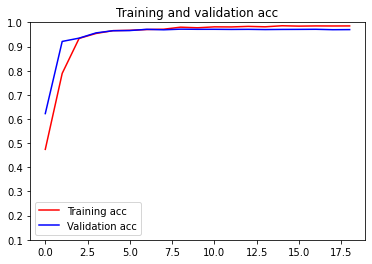

In [189]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=1,ymin=0.1)

plt.show()

## Regularization with Bidirectional - too complicated for this data set, won't consider for now

In [66]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(16, 5, activation='relu'))
model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.6,recurrent_dropout=0.5,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(16,dropout=0.6,recurrent_dropout=0.5)))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           128000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 32)            10272     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 16)            2576      
_________________________________________________________________
bidirectional (Bidirectional (None, 28, 64)            12544     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [67]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

#Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
#,callbacks = Es


keras.backend.clear_session()

Epoch 1/3
139/139 [==============================] - 30s 140ms/step - loss: 0.3956 - accuracy: 0.6328 - val_loss: 0.0937 - val_accuracy: 0.9503
Epoch 2/3
139/139 [==============================] - 18s 131ms/step - loss: 0.0878 - accuracy: 0.9646 - val_loss: 0.0592 - val_accuracy: 0.9575
Epoch 3/3
139/139 [==============================] - 18s 131ms/step - loss: 0.0464 - accuracy: 0.9772 - val_loss: 0.0570 - val_accuracy: 0.9547


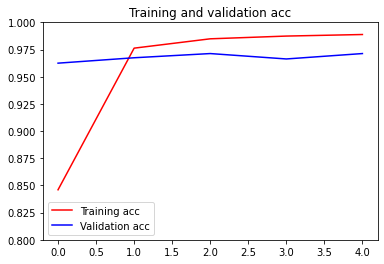

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.ylim(ymax=1,ymin=0.8)

plt.show()

chapter 4.4 glove
+dropout
+减少neurons
+batch size 往大调
+max_len 试试往小调
+max_feature 18000
+activation function sigmoid

## GloVe Embedding

In [162]:
import requests  
import os  
file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    
r = requests.get(file_url, stream = True)  

if not os.path.exists("glove.6B.zip"):
  print("Downloading...")
  with open("glove.6B.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
      if block:  
        file.write(block)  
else:
  print("Archive file already existed. Delete the original zip file if you want to re-download")


print("Uncompressing...")
!unzip 'glove.6B.zip'

Downloading...
Uncompressing...
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [164]:
import numpy as np

# glove_dir = '/home/ubuntu/data/'
#glove_dir = '/content/glove/'
glove_dir='./'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [193]:
max_words = 10000 #max_features
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_len)

In [194]:
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [203]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(layers.Conv1D(10, 5, activation='relu',kernel_regularizer="l2"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(5, 5, activation='relu',kernel_regularizer="l2"))
model.add(Dropout(0.5))
model.add(layers.LSTM(4,dropout=0.5,recurrent_dropout=0.5))
#model.add(layers.LSTM(8,dropout=0.4))
model.add(layers.Dense(1))

model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1500000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 10)            5010      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 10)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 5)             255       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [204]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

#Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
#,callbacks = Es

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 8s 70ms/step - loss: 0.7825 - accuracy: 0.3837 - val_loss: 0.5208 - val_accuracy: 0.8112
Epoch 2/50
70/70 [==============================] - 4s 64ms/step - loss: 0.4944 - accuracy: 0.6658 - val_loss: 0.2941 - val_accuracy: 0.7944
Epoch 3/50
70/70 [==============================] - 4s 64ms/step - loss: 0.3585 - accuracy: 0.7315 - val_loss: 0.2466 - val_accuracy: 0.8191
Epoch 4/50
70/70 [==============================] - 5s 65ms/step - loss: 0.3053 - accuracy: 0.7830 - val_loss: 0.2255 - val_accuracy: 0.8305
Epoch 5/50
70/70 [==============================] - 4s 64ms/step - loss: 0.2739 - accuracy: 0.8104 - val_loss: 0.1975 - val_accuracy: 0.8633
Epoch 6/50
70/70 [==============================] - 4s 64ms/step - loss: 0.2493 - accuracy: 0.8305 - val_loss: 0.1936 - val_accuracy: 0.8754
Epoch 7/50
70/70 [==============================] - 5s 65ms/step - loss: 0.2262 - accuracy: 0.8460 - val_loss: 0.1716 - val_accuracy: 0.8944
Epoch 8/50
70

### Increase neurons - even worse
### add more layers to make the architecture - worse

In [202]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(layers.Conv1D(16, 5, activation='relu',kernel_regularizer="l2"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(8, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.LSTM(8,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(layers.LSTM(8,dropout=0.4))
model.add(layers.Dense(1))

model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 16)            8016      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 8)             648       
_________________________________________________________________
dropout (Dropout)            (None, 28, 8)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 28, 8)             544       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 5

In [201]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy')

#Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/50
70/70 [==============================] - 11s 90ms/step - loss: 0.7681 - accuracy: 0.4046 - val_loss: 0.3391 - val_accuracy: 0.7933
Epoch 2/50
70/70 [==============================] - 5s 78ms/step - loss: 0.3462 - accuracy: 0.7428 - val_loss: 0.2532 - val_accuracy: 0.8241
Epoch 3/50
70/70 [==============================] - 6s 79ms/step - loss: 0.2710 - accuracy: 0.8193 - val_loss: 0.2199 - val_accuracy: 0.8719
Epoch 4/50
70/70 [==============================] - 6s 80ms/step - loss: 0.2352 - accuracy: 0.8486 - val_loss: 0.1872 - val_accuracy: 0.8793
Epoch 5/50
70/70 [==============================] - 6s 79ms/step - loss: 0.2052 - accuracy: 0.8739 - val_loss: 0.1672 - val_accuracy: 0.9067
Epoch 6/50
70/70 [==============================] - 6s 79ms/step - loss: 0.1815 - accuracy: 0.8905 - val_loss: 0.1394 - val_accuracy: 0.9165
Epoch 7/50
70/70 [==============================] - 6s 80ms/step - loss: 0.1554 - accuracy: 0.9072 - val_loss: 0.1543 - val_accuracy: 0.8846
Epoch 8/50
7